In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cohen_kappa_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
import seaborn as sns 
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report

from optuna.visualization import plot_optimization_history
import logging




import warnings
warnings.filterwarnings('ignore', category=UserWarning)  
warnings.filterwarnings('ignore', category=FutureWarning)

c:\Users\gerar\Desktop\githubRepo\-AI-Projects\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
print(len(train))
testAns = test.copy()

15000


In [3]:
train = train.drop(columns=["id"])
test = test.drop(columns=["id"])

In [4]:
train["quality"] = train["quality"] - 3

In [5]:
def add_columns(df):
    df = df.copy()
    df["total_acid"] = df["fixed acidity"] + df["volatile acidity"] + df["citric acid"]
    df["acid/density"] = df["total_acid"] / df["density"]
    df["alcohol_density"] = df["alcohol"] * df["density"]
    df["sulphate/density"] = df["sulphates"] / df["density"]
    df["sulphates/acid"] = df["sulphates"] / df["volatile acidity"]
    df["sulphates/chlorides"] = df["sulphates"] / df["chlorides"]
    df["sulphates*alcohol"] = df["sulphates"] * df["alcohol"]
    df["pH_round1"] = df["pH"].round(1)
    df["log1p_residual_sugar"] = np.log1p(df["residual sugar"])
    df["citric_acid_per_alcohol"] = np.where(df["alcohol"] == 0, 0, df["citric acid"] / df["alcohol"])
    df["citric_acid_type"] = df["citric acid"].apply(lambda x: 0 if x == 0 else (1 if x == 0.49 else 2))
    df["alcohol_mean_groupby_pH"] = df.groupby("pH_round1")["alcohol"].transform("mean")


    df['volatile_acidity_per_total_acid'] = df['volatile acidity'] / (df['total_acid'] + 1e-6)
    df['alcohol_per_residual_sugar'] = df['alcohol'] / (df['residual sugar'] + 1e-6)
    df['free_to_total_sulfur_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1e-6)
    df['sugar_density_ratio'] = df['residual sugar'] / (df['density'] + 1e-6)
    df['acidity_times_alcohol'] = df['total_acid'] * df['alcohol']
    df['citric_acid_squared'] = df['citric acid'] ** 2
    df['sulphates_log'] = np.log1p(df['sulphates'])




    return df

In [6]:
def process_data(df):
    processed_df = df.assign(
        pH_round1=df['pH'].round(1),
        log1p_residual_sugar=np.log1p(df['residual sugar']),
        citric_acid_per_alcohol=np.where(
            df['alcohol'] == 0, 
            0, 
            df['citric acid'] / df['alcohol']
        )
    ).assign(
        citric_acid_type=df['citric acid'].apply(
            lambda x: 0 if x == 0 else (1 if x == 0.49 else 2)
        ),
        alcohol_mean_groupby_pH=lambda x: x.groupby('pH_round1')['alcohol'].transform('mean')
    )
    
    return processed_df

In [7]:
train = add_columns(train)
test = add_columns(test)
train = process_data(train)
test = process_data(test)

numeric_cols = train.drop(columns=['quality']).select_dtypes(include=np.number).columns


kmeans = KMeans(n_clusters=3, random_state=42)
train['cluster'] = kmeans.fit_predict(train[numeric_cols])
test['cluster'] = kmeans.predict(test[numeric_cols])




In [8]:
numeric_cols = train.select_dtypes(include=np.number).drop(columns=["quality"]).columns

kmeans = KMeans(n_clusters=3, random_state=42)
train['cluster'] = kmeans.fit_predict(train[numeric_cols])
test['cluster'] = kmeans.predict(test[numeric_cols])


def add_cols(df):
    df['alcohol_cluster_interaction'] = df['alcohol'] * df['cluster']
    df['acid_cluster_interaction'] = df['total_acid'] * df['cluster']
    return df 

train = add_cols(train)
test = add_cols(test)


numeric_cols = train.drop(columns=['quality']).columns
train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'total_acid', 'acid/density',
       'alcohol_density', 'sulphate/density', 'sulphates/acid',
       'sulphates/chlorides', 'sulphates*alcohol', 'pH_round1',
       'log1p_residual_sugar', 'citric_acid_per_alcohol', 'citric_acid_type',
       'alcohol_mean_groupby_pH', 'volatile_acidity_per_total_acid',
       'alcohol_per_residual_sugar', 'free_to_total_sulfur_ratio',
       'sugar_density_ratio', 'acidity_times_alcohol', 'citric_acid_squared',
       'sulphates_log', 'cluster', 'alcohol_cluster_interaction',
       'acid_cluster_interaction'],
      dtype='object')

In [9]:
X = train.drop(columns=['quality'])
y = train['quality']

scaler = StandardScaler()
X =  scaler.fit_transform(X)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [11]:
xgb = XGBClassifier(use_label_encoder=False,random_state=42)



In [12]:
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
# def evaluate(model, name):
#     preds = model.predict(X_val)
#     score = cohen_kappa_score(y_val, preds, weights='quadratic')
#     print(f"{name} Quadratic Kappa Score: {score:.4f}")
#     return model.predict(test)

def evaluate(model, name, X_val=None, y_val=None):
    preds = model.predict(X_val)
    score = cohen_kappa_score(y_val, preds, weights='quadratic')
    print(f"{name} Quadratic Kappa Score: {score:.4f}")
    return model.predict(test)


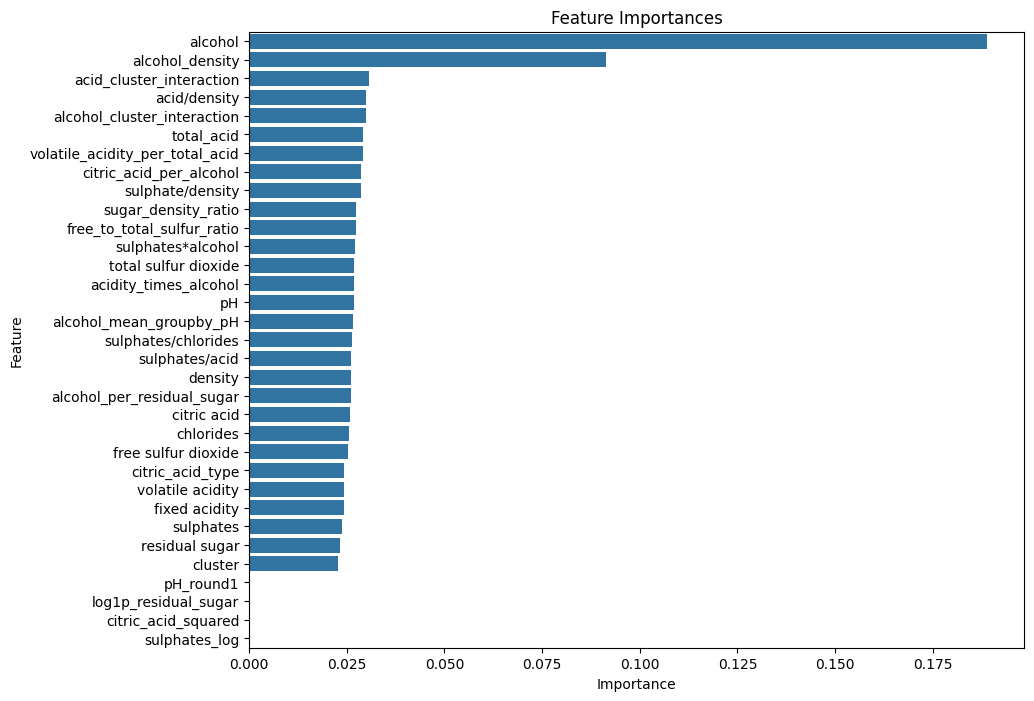

,Feature,Importance
0,alcohol,0.188925
1,alcohol_density,0.091334
2,acid_cluster_interaction,0.030683
3,acid/density,0.029948
4,alcohol_cluster_interaction,0.029870
5,total_acid,0.029260
6,volatile_acidity_per_total_acid,0.029151
7,citric_acid_per_alcohol,0.028784
8,sulphate/density,0.028708
9,sugar_density_ratio,0.027387


In [14]:
feature_importances = pd.DataFrame({
    'Feature': test.columns,
    'Importance': xgb.feature_importances_
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()
feature_importances


In [15]:
rfe = RFE(estimator=xgb, n_features_to_select=20)
rfe.fit(X_train, y_train)

ranking = rfe.ranking_
selected_features = test.columns[rfe.support_]

print("Selected Features:")
print(selected_features)

feature_ranking = pd.DataFrame({
    'Feature': test.columns,
    'Ranking': ranking
}).sort_values(by='Ranking')

print("\nFeature Ranking:")
print(feature_ranking)

Selected Features:
Index(['citric acid', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'alcohol', 'total_acid', 'acid/density', 'alcohol_density',
       'sulphate/density', 'sulphates/acid', 'sulphates/chlorides',
       'sulphates*alcohol', 'citric_acid_per_alcohol',
       'volatile_acidity_per_total_acid', 'free_to_total_sulfur_ratio',
       'sugar_density_ratio', 'acidity_times_alcohol',
       'alcohol_cluster_interaction', 'acid_cluster_interaction'],
      dtype='object')

Feature Ranking:
                            Feature  Ranking
2                       citric acid        1
7                           density        1
6              total sulfur dioxide        1
5               free sulfur dioxide        1
12                     acid/density        1
11                       total_acid        1
10                          alcohol        1
8                                pH        1
14                 sulphate/density        1
13                  a

In [16]:
preds_xgb = evaluate(model=xgb, name="XGBoost" , X_val=X_val , y_val=y_val)
model_predictv1 = xgb.predict(X_val)
classification_report(y_val , model_predictv1)

XGBoost Quadratic Kappa Score: 0.3152


'              precision    recall  f1-score   support\n\n         0.0       0.00      0.00      0.00        14\n         1.0       0.00      0.00      0.00        84\n         2.0       0.58      0.69      0.63      1305\n         3.0       0.47      0.48      0.47      1192\n         4.0       0.41      0.25      0.31       365\n         5.0       0.00      0.00      0.00        40\n\n    accuracy                           0.52      3000\n   macro avg       0.24      0.24      0.23      3000\nweighted avg       0.49      0.52      0.50      3000\n'

In [17]:
y_selected = train['quality']

In [18]:


train = train[selected_features]

test =  test[selected_features]
X_selected = train

scaler = StandardScaler()
X_selected =  scaler.fit_transform(X_selected)
test = scaler.fit_transform(test)

X_train_selected, X_val_selected, y_train_selected, y_val_selected = train_test_split(X_selected, y_selected, stratify=y, test_size=0.2, random_state=42)


xgbV2 = XGBClassifier(use_label_encoder=False,random_state=42)
xgbV2.fit(X_train_selected, y_train_selected)

print(X_train_selected.shape , X_val_selected.shape)

preds_xgb = evaluate(model=xgbV2, name="XGBoost" , X_val=X_val_selected , y_val=y_val_selected)
model_predict = xgbV2.predict(X_val_selected)

(12000, 20) (3000, 20)
XGBoost Quadratic Kappa Score: 0.3165


In [19]:
classification_report(y_val_selected , model_predict)

'              precision    recall  f1-score   support\n\n         0.0       0.00      0.00      0.00        14\n         1.0       0.00      0.00      0.00        84\n         2.0       0.58      0.68      0.63      1305\n         3.0       0.46      0.48      0.47      1192\n         4.0       0.44      0.25      0.32       365\n         5.0       0.00      0.00      0.00        40\n\n    accuracy                           0.52      3000\n   macro avg       0.25      0.24      0.24      3000\nweighted avg       0.49      0.52      0.50      3000\n'

In [ ]:
# from sklearn.metrics import cohen_kappa_score
# from xgboost import XGBClassifier
# import optuna
# from optuna.samplers import TPESampler

# def xgb_objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "use_label_encoder": False,
#         "eval_metric": "mlogloss",
#         "random_state": 42,
#         "early_stopping_rounds": 50  
#     }

#     model = XGBClassifier(**params)
#     evals = [(X_val, y_val)]
#     model.fit(X_train, y_train, eval_set=evals, verbose=False)
    
#     preds = model.predict(X_val)
#     return cohen_kappa_score(y_val, preds, weights="quadratic")

# study_xgb = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
# study_xgb.optimize(xgb_objective, n_trials=30)
# xgb_best = XGBClassifier(**study_xgb.best_params)
# xgb_best.fit(X, y)
# final_preds_xgb = xgb_best.predict(test)




def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 2.0),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "tree_method": trial.suggest_categorical("tree_method", ["auto", "exact", "approx", "hist"]),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "use_label_encoder": False,
        "eval_metric": "mlogloss",
        "random_state": 42,
        "n_jobs": -1 , 
        "early_stop" : 50
    }

    model = XGBClassifier(**params)
    early_stop = trial.suggest_int("early_stopping_rounds", 20, 100, step=10)
    
    model.fit(
        X_train_selected, y_train_selected,
        eval_set=[(X_val_selected, y_val_selected)],
        verbose=False
    )
    
    preds = model.predict(X_val_selected)
    kappa = cohen_kappa_score(y_val_selected, preds, weights="quadratic")
    
    # Prune les essais non prometteurs
    trial.report(kappa, step=1)
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return kappa

study_xgb = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42, n_startup_trials=20, multivariate=True),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=20,
        reduction_factor=3
    )
)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

def log_callback(study, trial):
    logger.info(f"Trial {trial.number} finished with value: {trial.value}")

study_xgb.optimize(xgb_objective, n_trials=50, callbacks=[log_callback])

print("Best trial:")
trial = study_xgb.best_trial
print(f"  Kappa: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

plot_optimization_history(study_xgb)

best_params = study_xgb.best_params.copy()
early_stop = best_params.pop("early_stopping_rounds")

xgb_best = XGBClassifier(**best_params)
xgb_best.fit(
    X_train_selected, y_train_selected,
    eval_set=[(X_val_selected, y_val_selected)],
    verbose=True
)

final_preds = xgb_best.predict(X_val_selected)
print("\nClassification Report:")
print(classification_report(y_val_selected, final_preds))



c:\Users\gerar\Desktop\githubRepo\-AI-Projects\.venv\lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-14 21:10:12,497] A new study created in memory with name: no-name-6944565f-004a-4a2e-a20f-92a7194fd54b
[I 2025-05-14 21:10:17,580] Trial 0 finished with value: 0.2570522119368406 and parameters: {'n_estimators': 800, 'learning_rate': 0.3285970816964244, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 0.15601864044243652, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.08499808989182997, 'reg_lambda': 0.0006440507553993703, 'scale_pos_weight': 1.5621088666940683, 'max_delta_step': 0, 'tree_method': 'auto', 'grow_policy': 'lossguide', 'early_stopping_rounds': 60}. Best is trial 0 with value: 0.2570522119368406.
INFO:root:Trial 0 finished with value: 0.2570522119368406
[I 2025-05-14 21:10:54,380] Trial 1 finish

In [ ]:
final_preds_xgb = xgbV2.predict(test)


In [ ]:
from sklearn.metrics import classification_report

val_preds = xgb_best.predict(X_val_selected)
report_df_xgb = pd.DataFrame(classification_report(y_val_selected, val_preds, output_dict=True)).transpose()
report_df_xgb   

,precision,recall,f1-score,support
0.0,0.000000,0.000000,0.000000,14.000
1.0,0.000000,0.000000,0.000000,84.000
2.0,0.604361,0.743295,0.666667,1305.000
3.0,0.489015,0.504195,0.496489,1192.000
4.0,0.512048,0.232877,0.320151,365.000
5.0,0.000000,0.000000,0.000000,40.000
accuracy,0.552000,0.552000,0.552000,0.552
macro avg,0.267571,0.246728,0.247218,3000.000
weighted avg,0.519499,0.552000,0.526223,3000.000


In [ ]:
final_preds = final_preds_xgb.astype(int) + 3  




In [ ]:
sample_submission['quality'] = final_preds
sample_submission.to_csv("submission.csv", index=False)

In [ ]:
sample_submission['quality'].unique()

array([6, 5, 7, 4, 8, 3])